In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, skeletonize
import pandas as pd
from matplotlib import animation
from matplotlib import rcParams
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from pyfcd.fcd import calculate_carriers, fcd, normalize_image

THRESHOLD = 120
MAX_PIXEL_VALUE = 255
MM2_CALIBRATION = 1000*(924)*1e-6  #largo*(diametro) de la cabecilla [µm^2 -> mm^2]
PX_PER_M = 7.532343134764206*1e3 # [px/mm -> px/m]
PX_PER_MM = 7.532343134764206 # [px/mm]
SQUARE_SIZE = 2*1e-3 # [mm] -> [m]

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR

# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

In [13]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY', threshold = THRESHOLD):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, threshold, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def obtener_deformacion(vs, carriers, SHOW=False):
    camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax
    frame_count = int(vs.get(7))
    width  = int(vs.get(3))  # float `width`
    height = int(vs.get(4)) - (int(vs.get(4)) - 600) - (110)  # float `height`
    i=0
    maps = np.zeros((frame_count,height,width))
    image_stack = np.zeros((frame_count,height,width))
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            frame[camo_mask[0]:camo_mask[1],camo_mask[2]:camo_mask[3]] = 0
            frame = binarize(gris(frame[110:600,:]),threshold=160)
            #frame = gris(frame[110:600,:])
            height_map = fcd(frame, carriers, unwrap=True)
            image_stack[i] = frame
            maps[i] = height_map
            if SHOW:
                cv.imshow('frame', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
            i+=1
        else:
            break
        
    cv.destroyAllWindows()
    return maps, image_stack

In [4]:
FILENAME='P1-2V-9Hz'
camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax

vs = cv.VideoCapture(f'videos/FCD/negro/{FILENAME}.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret:
        frame[camo_mask[0]:camo_mask[1],camo_mask[2]:camo_mask[3]] = 0
        frame = binarize(gris(frame[110:600,:]),threshold=160)
        if i==0:
            ref_frame = frame
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [6]:
vs = cv.VideoCapture(f'videos/FCD/negro/{FILENAME}.mp4')

carriers = calculate_carriers(ref_frame, square_size = SQUARE_SIZE)

maps, frame_stack = obtener_deformacion(vs,carriers, SHOW=True)

In [7]:
max_height = max([abs(maps[i]).max()/10 for i in np.arange(len(maps))])

norm = plt.Normalize(-max_height, max_height)
cmap = plt.colormaps.get_cmap('seismic')
colorscale = plt.cm.ScalarMappable(norm, cmap)

for i in tqdm(np.arange(len(maps))[300:]):
    fig, ax = plt.subplots()
    curr_map = maps[i]
    curr_map[camo_mask[0]:600,camo_mask[2]:camo_mask[3]] = 0
    im = ax.imshow(maps[i],cmap=cmap, aspect='equal')

    cbar_term = fig.colorbar(colorscale, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.0209)
    cbar_term.ax.set_ylim(-max_height,max_height)
    cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
    cbar_term.ax.set_ylabel('Altura',labelpad=40)
    fig.tight_layout()
    # np.save(f'schlieren_maps/P1_2V_9Hz/frame_data/{str(i)}.npy',maps[i],allow_pickle=True)
    fig.savefig(f'schlieren_maps/{FILENAME}/images/{str(i)}.tiff')
    plt.close()

100%|██████████| 118/118 [00:38<00:00,  3.08it/s]


#### Longitud de onda de propagación

In [102]:
found_waves = list([
    dict({
        "i":120,
        "xmin":200,
        "xmax":800
    }),
    dict({
        "i":124,
        "xmin":0,
        "xmax":600
    }),
    dict({
        "i":194,
        "xmin":600,
        "xmax":1000
    }),
    dict({
        "i":178,
        "xmin":400,
        "xmax":800
    }),
    dict({
        "i":171,
        "xmin":300,
        "xmax":800
    }),
    dict({
        "i":186,
        "xmin":500,
        "xmax":850
    }),
])

In [8]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

Text(0.5, 0, '$k$')

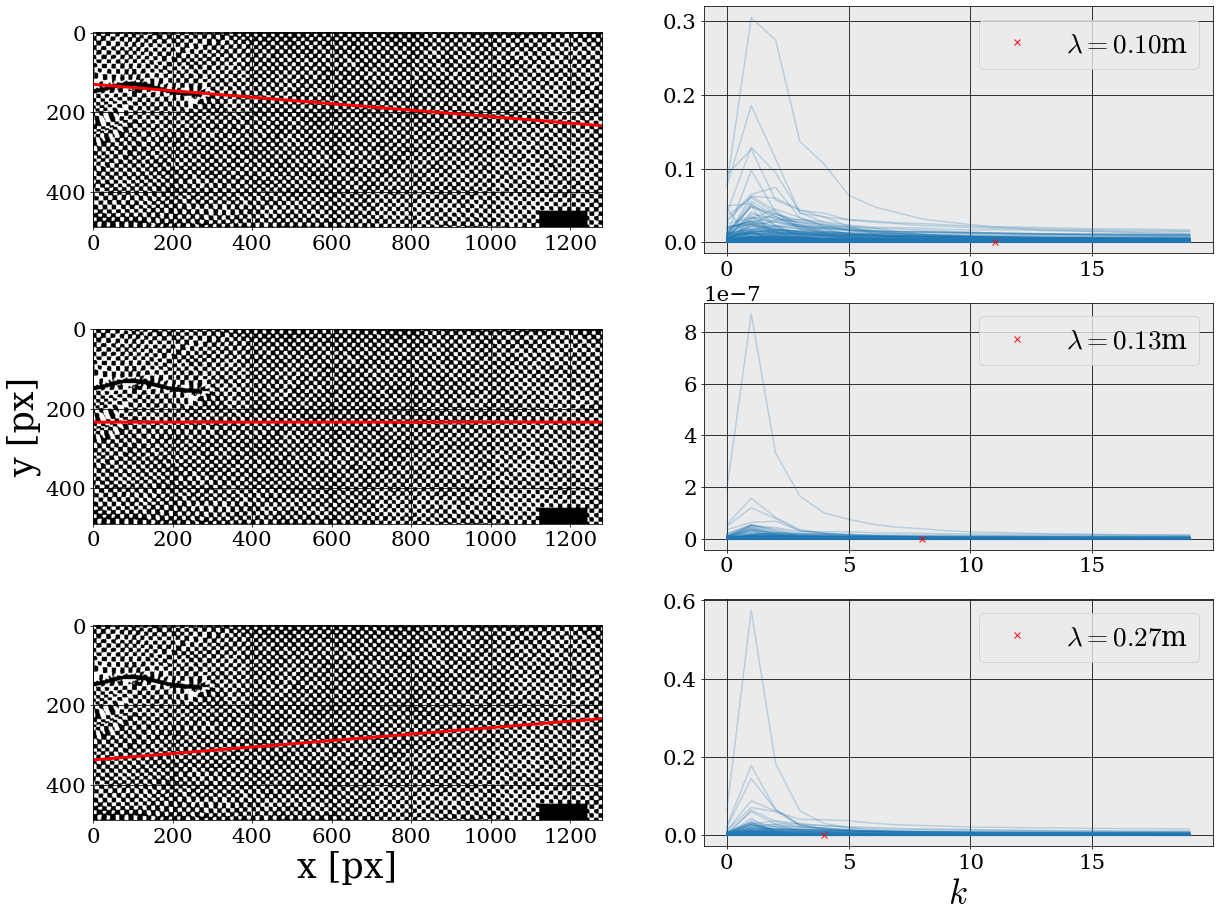

In [10]:
fig,axs = plt.subplots(3,2)

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]
ax5 = axs[2,0]
ax6 = axs[2,1]

set_size(16,12,ax2)


x_len = maps[0].shape[1]
y_len = maps[0].shape[0]


f_lineal = lambda x,a,b: x*a + b

amplitud_y = np.zeros((len(maps),x_len)) #Creamos una matriz donde va a ir la amplitud sobre esa recta tiempo a tiempo

#PARA LA PRIMERA RECTA

#Definimos los vectores donde vamos a poner la información de la transformada de fourier
amp_fft = np.zeros((len(maps),x_len//2))
ks_fft = np.fft.fftfreq(amplitud_y[0].size)[:x_len//2]
lam_fft = np.zeros((len(maps)))

#Definimos una recta por la cual medimos las deformaciones
y_amplitud = f_lineal(np.arange(0,1280)-1280,(234-130)/1280, 234)
y_int = np.array(y_amplitud).astype(int) #Pasamos la recta a enteros para poder indexar correctamente

#Obtenemos la amplitud sobre la recta definida para cada tiempo
for i in np.arange(len(maps)):
    for y,x in zip(y_int,np.arange(x_len)):
        amplitud_y[i,x] = maps[i][y,x]/PX_PER_MM #Utilizamos la calibración en este momento
    amplitud_y[i] = amplitud_y[i][::-1] #Damos vuelta el vector de amplitud para que vaya tener ondas viajeras hacia la derecha

#Sumamos y promediamos la transformada de fourier para cada tiempo
for i,amp in enumerate(amplitud_y):
    amp_fft[i] = (np.abs(np.fft.fft(amp))**2)[:x_len//2]
    lam_fft[i] = np.argmax(amp_fft[i])
    ax2.plot(amp_fft[i][:20],alpha=0.25,color='tab:blue')

#Ploteamos la recta por la que miramos la amplitud de las ondas
ax1.imshow(frame_stack[320], cmap='gray')
ax1.plot(np.arange(0,1280),y_amplitud, lw=3, color='r')

#Ploteamos la suma de todas las transformadas de fourier con su respectivo número de onda
lam_i = int(np.average(lam_fft))
ax2.plot(np.average(amp_fft[:20],axis=0)[:20])
ax2.plot(lam_i, np.average(amp_fft[:20],axis=0)[lam_i],'x', color='r', label=f'$\lambda = {(2*np.pi/ks_fft[lam_i])/PX_PER_M:.2f}$m')
ax2.legend()

#PARA LA SEGUNDA RECTA

#Definimos los vectores donde vamos a poner la información de la transformada de fourier
amp_fft = np.zeros((len(maps),x_len//2))
ks_fft = np.fft.fftfreq(amplitud_y[0].size)[:x_len//2]

#Definimos una recta por la cual medimos las deformaciones
y_amplitud = f_lineal(np.arange(0,1280)-1280,0*(234-130)/1280, 234)
y_int = np.array(y_amplitud).astype(int) #Pasamos la recta a enteros para poder indexar correctamente

#Obtenemos la amplitud sobre la recta definida para cada tiempo
for i in np.arange(len(maps)):
    for y,x in zip(y_int,np.arange(x_len)):
        amplitud_y[i,x] = maps[i][y,x]/PX_PER_M #Utilizamos la calibración en este momento
    amplitud_y[i] = amplitud_y[i][::-1] #Damos vuelta el vector de amplitud para que vaya tener ondas viajeras hacia la derecha

#Sumamos y promediamos la transformada de fourier para cada tiempo
for i,amp in enumerate(amplitud_y):
    amp_fft[i] = (np.abs(np.fft.fft(amp))**2)[:x_len//2]
    lam_fft[i] = np.argmax(amp_fft[i])
    ax4.plot(amp_fft[i][:20],alpha=0.25,color='tab:blue')

#Ploteamos la recta por la que miramos la amplitud de las ondas
ax3.imshow(frame_stack[320], cmap='gray')
ax3.plot(np.arange(0,1280),y_amplitud, lw=3, color='r')

#Ploteamos la suma de todas las transformadas de fourier con su respectivo número de onda
lam_i = int(np.average(lam_fft))
ax4.plot(np.average(amp_fft[:20],axis=0)[:20])
ax4.plot(lam_i, np.average(amp_fft[:20],axis=0)[lam_i],'x', color='r', label=f'$\lambda = {(2*np.pi/ks_fft[lam_i])/PX_PER_M:.2f}$m')
ax4.legend()

#PARA LA TERCERA RECTA

#Definimos los vectores donde vamos a poner la información de la transformada de fourier
amp_fft = np.zeros((len(maps),x_len//2))
ks_fft = np.fft.fftfreq(amplitud_y[0].size)[:x_len//2]

#Definimos una recta por la cual medimos las deformaciones
y_amplitud = f_lineal(np.arange(0,1280)-1280,-1*(234-130)/1280, 234)
y_int = np.array(y_amplitud).astype(int) #Pasamos la recta a enteros para poder indexar correctamente

#Obtenemos la amplitud sobre la recta definida para cada tiempo
for i in np.arange(len(maps)):
    for y,x in zip(y_int,np.arange(x_len)):
        amplitud_y[i,x] = maps[i][y,x]/PX_PER_MM #Utilizamos la calibración en este momento
    amplitud_y[i] = amplitud_y[i][::-1] #Damos vuelta el vector de amplitud para que vaya tener ondas viajeras hacia la derecha

#Sumamos y promediamos la transformada de fourier para cada tiempo
for i,amp in enumerate(amplitud_y):
    amp_fft[i] = (np.abs(np.fft.fft(amp))**2)[:x_len//2]
    lam_fft[i] = np.argmax(amp_fft[i])
    ax6.plot(amp_fft[i][:20],alpha=0.25,color='tab:blue')

#Ploteamos la recta por la que miramos la amplitud de las ondas
ax5.imshow(frame_stack[320], cmap='gray')
ax5.plot(np.arange(0,1280),y_amplitud, lw=3, color='r')

#Ploteamos la suma de todas las transformadas de fourier con su respectivo número de onda
lam_i = int(np.average(lam_fft))
ax6.plot(np.average(amp_fft[:20],axis=0)[:20])
ax6.plot(lam_i, np.average(amp_fft[:20],axis=0)[lam_i],'x', color='r', label=f'$\lambda = {(2*np.pi/ks_fft[lam_i])/PX_PER_M:.2f}$m')
ax6.legend()

ax3.set_ylabel('y [px]')
ax5.set_xlabel('x [px]')
ax6.set_xlabel('$k$')